# Notebook 4

## Digital health and computational epidemiology
Author: Michele Tizzoni

---

In this notebook, we'll use the Python library ["Epidemics on Networks" developed by Kiss, Miller & Simon](https://github.com/springer-math/Mathematics-of-Epidemics-on-Networks).

The library must be installed using pip:

    pip install EoN
  

The library documentation is [available here](http://epidemicsonnetworks.readthedocs.io/en/latest/). 

In [1]:
import EoN
import networkx as nx
import numpy as np
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
from operator import itemgetter


In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

# Simulate the spread of a SIR epidemic on the US airport network

In [4]:
airport_path = "./../datasets/USairport_2010.txt"
meta_path = "./../datasets/USairport_2010_codes.txt"

In [5]:
G = nx.Graph()
fh = open(airport_path, "r")
for line in fh.readlines():
    s = line.strip().split()
    G.add_edge(int(s[0]), int(s[1]))
fh.close()

In [6]:
G.code = {}
G.name = {}
G.pos = {}

lons = []
lats = []

finfo = open(meta_path, "r")
for line in finfo.readlines():
    s = line.strip().split()
    node = int(s[0])

    lon = float(s[4])
    lat = float(s[3])

    G.code[node] = s[1]
    G.name[node] = s[2]
    G.pos[node] = [lon, lat]

    lons.append(lon)
    lats.append(lat)
finfo.close()

In [7]:
# disease parameters
mu = 0.1  # infectious period
lambd = 0.01  # probability of infection given a contact

In [8]:
# we need to store the disease status of each node
G.disease_status = {}  # S=0, I=1, R=-1

infected_nodes = []  # list of infected nodes

In [9]:
# let's choose a seed
node_list = []

deg = dict(G.degree())
for i in sorted(deg.items(), key=itemgetter(1)):
    node_list.append(i[0])
seed = node_list[-1]

print("The seed is", G.name[seed])
print("The degree of the seed is", G.degree(seed))

The seed is Denver
The degree of the seed is 192


In [10]:
# initialize the network
infected_nodes.append(seed)

for n in G.nodes():
    if n in infected_nodes:
        G.disease_status[n] = 1
        # infected
    else:
        G.disease_status[n] = 0
        # susceptible

In [11]:
I_net = []

while len(infected_nodes) > 0:

    # transmission
    for i in infected_nodes:
        for j in G.neighbors(i):
            if G.disease_status[j] == 0:
                p = np.random.random()
                if p < lambd:
                    G.disease_status[j] = 1

    # recovery
    for k in infected_nodes:
        p = np.random.random()
        if p < mu:
            G.disease_status[k] = -1

    # update of disease status
    infected_nodes = []
    for n in G.nodes():
        if G.disease_status[n] == 1:
            infected_nodes.append(n)

    # store output
    I_net.append(len(infected_nodes))

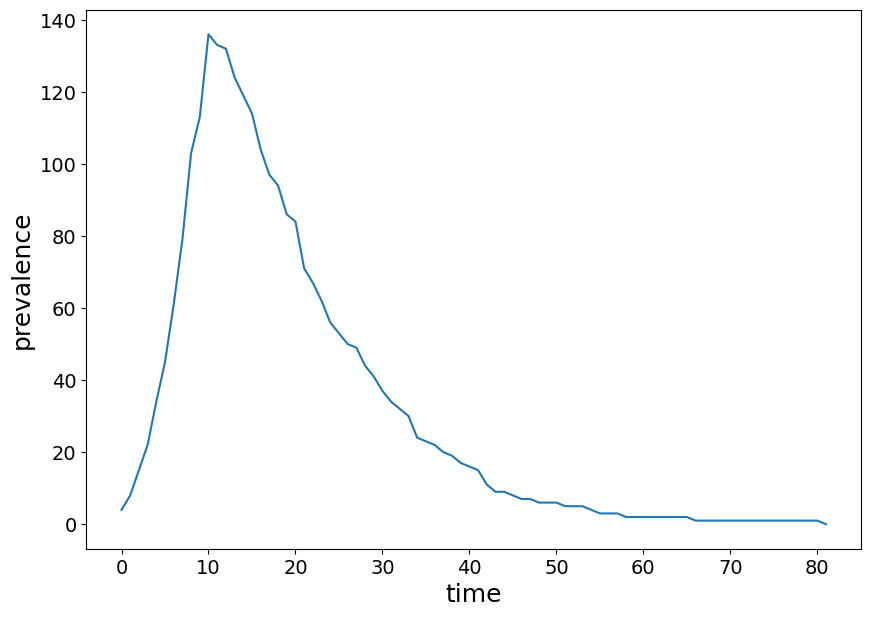

In [12]:
plt.figure(figsize=(10, 7))

plt.xlabel("time", fontsize=18)
plt.ylabel("prevalence", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.plot(range(0, len(I_net)), I_net)

In [13]:
recovered = 0
for n in G.nodes():
    if G.disease_status[n] == -1:
        recovered += 1

print("The total number of infected nodes is", recovered)
print("The final attack rate is", recovered / len(G.nodes()))

The total number of infected nodes is 264
The final attack rate is 0.6518518518518519


# Combine NetworkX and Geopandas to visualize the spreading

In [14]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [15]:
from pyproj import Transformer, transform

In [16]:
shape_path = "./../shapefiles/USA_shape.shp"

We import the USA shapefile

In [17]:
usa = gpd.read_file(shape_path)

<AxesSubplot: >

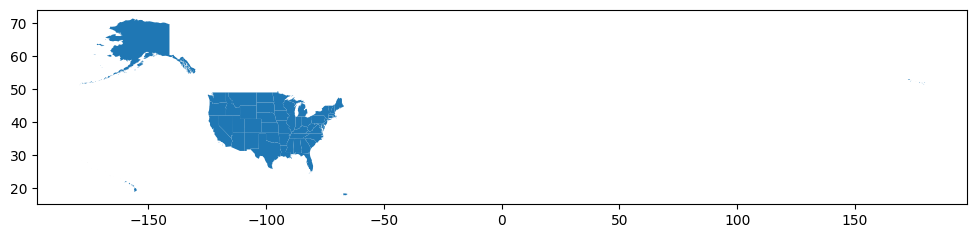

In [18]:
usa.plot(figsize=(12, 7))

In [19]:
usa.head()

,AREA,PERIMETER,ST99_D00_,ST99_D00_I,STATE,NAME,LSAD,REGION,DIVISION,LSAD_TRANS,geometry
0,271.25438,227.17142,2,1,02,Alaska,01,4,9,None,"POLYGON ((-147.78711 70.24536, -147.76510 70.2..."
1,0.00375,0.34984,3,2,02,Alaska,01,4,9,None,"POLYGON ((-166.05315 66.26494, -166.03187 66.2..."
2,0.00150,0.15353,4,3,02,Alaska,01,4,9,None,"POLYGON ((-168.89322 65.74470, -168.89875 65.7..."
3,0.03130,0.71223,5,4,02,Alaska,01,4,9,None,"POLYGON ((-168.21012 64.99896, -168.20791 65.0..."
4,0.88934,7.36032,6,5,02,Alaska,01,4,9,None,"POLYGON ((-171.73986 63.71712, -171.73321 63.7..."


In [20]:
usa_cont = usa[
    (usa.NAME != "Alaska") & (usa.NAME != "Hawaii") & (usa.NAME != "Puerto Rico")
]

In [21]:
usa_cont.head()

,AREA,PERIMETER,ST99_D00_,ST99_D00_I,STATE,NAME,LSAD,REGION,DIVISION,LSAD_TRANS,geometry
81,25.53950,31.40718,83,82,27,Minnesota,01,2,4,None,"POLYGON ((-95.15332 49.19311, -95.15342 49.249..."
82,20.85358,30.71739,84,83,53,Washington,01,4,9,None,"POLYGON ((-122.29069 49.00243, -122.28565 49.0..."
83,0.00152,0.17436,85,84,53,Washington,01,4,9,None,"POLYGON ((-123.09055 49.00198, -123.06793 49.0..."
84,45.07846,34.97623,86,85,30,Montana,01,4,8,None,"POLYGON ((-116.04919 49.00091, -116.00103 49.0..."
85,24.45683,29.19034,87,86,16,Idaho,01,4,8,None,"POLYGON ((-116.04919 49.00091, -116.04918 48.8..."


<AxesSubplot: >

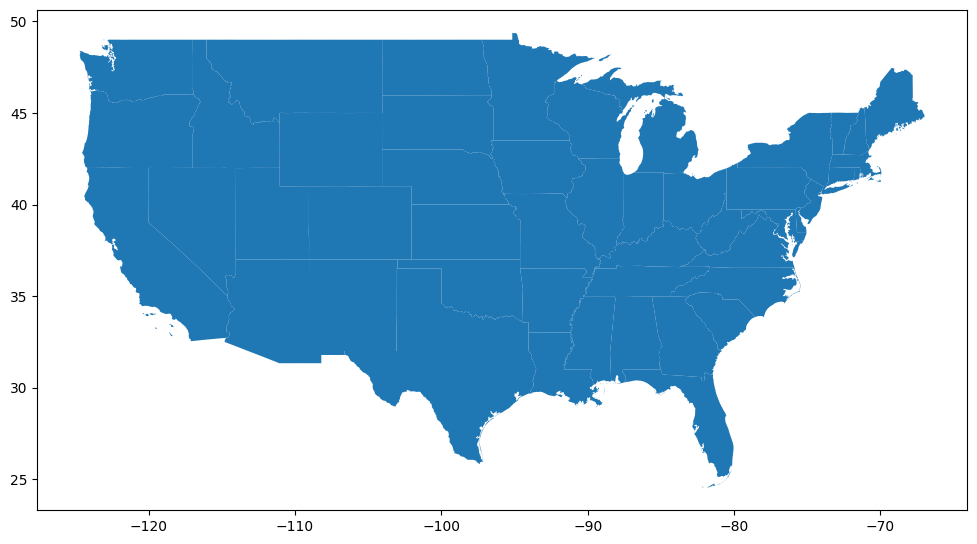

In [22]:
usa_cont.plot(figsize=(12, 7))

In [23]:
usa_cont.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
usa_cont_alb = usa_cont.to_crs('esri:102003')

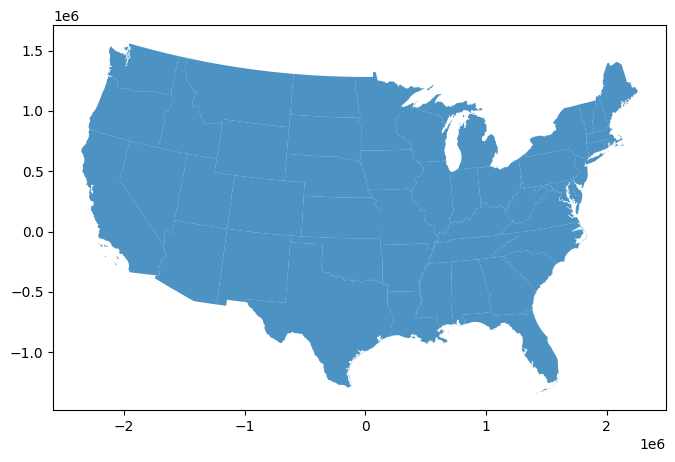

In [25]:
ax = usa_cont_alb.plot(figsize=(10, 5), alpha=0.8)

In [26]:
usa_cont_alb.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: USA_Contiguous_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Load metadata

In [27]:
df = pd.read_csv(meta_path, sep=" ", names=["id", "code", "name", "lat", "lon"])

In [28]:
df

,id,code,name,lat,lon
0,29,ABE,Allentown,40.654722,-75.438333
1,30,ABI,Abilene,32.409444,-99.679722
2,32,ABQ,Albuquerque,35.041667,-106.606389
3,33,ABR,Aberdeen,45.449722,-98.421667
4,35,ABY,Albany,31.532222,-84.196111
...,...,...,...,...,...
410,1748,WYS,West_Yellowstone,44.686667,-111.104722
411,1752,XNA,Fayetteville,36.281944,-94.306944
412,1788,YKM,Yakima,46.566944,-120.537778
413,1795,YNG,Youngstown,41.256111,-80.669722


In [29]:
geo = [Point(xy) for xy in zip(df.lon, df.lat)]
#crs = {"init": "epsg:4326"}
crs=4326
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geo)

In [30]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

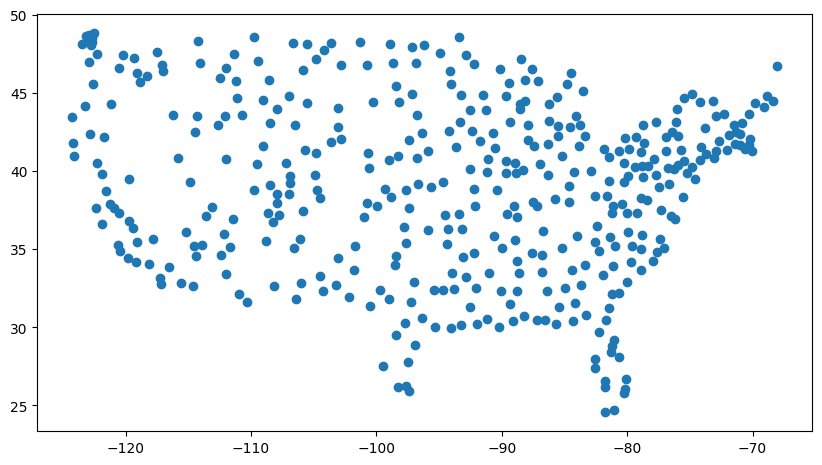

In [31]:
geo_df.plot(figsize=(10, 7))

In [32]:
original = 'epsg:4326'  # EPSG:4326 in your case
destination =   usa_cont_alb.crs # your new proj

In [33]:
transformer = Transformer.from_crs(original, destination)

In [34]:
G.pos_new = {}

for node in G:

    long, lat = G.pos[node]
    
    x, y = transformer.transform(lat, long)

    G.pos_new[node] = (x, y)

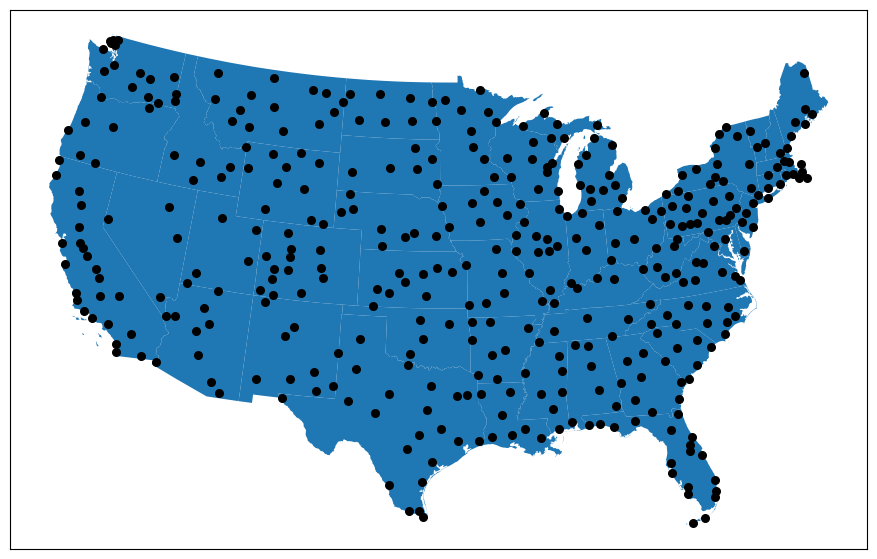

In [35]:
ax = usa_cont_alb.plot(figsize=(12, 7), alpha=1.)

nx.draw_networkx_nodes(
    G,
    pos=G.pos_new,
    node_size=30,
    node_color='black'
)

# SIR simulation

In [36]:
G.disease_status = {}  # S=0, I=1, R=-1

infected_nodes = []  # list of infected nodes

In [37]:
# initialize the network
infected_nodes.append(seed)

for n in G.nodes():
    if n in infected_nodes:
        G.disease_status[n] = 1
        # infected
    else:
        G.disease_status[n] = 0
        # susceptible

In [38]:
t = 0
node_color = [G.disease_status[v] for v in G]  # color code on disease status

/var/folders/9_/spyk69pj2nl_0yvc80p_m_680000gp/T/ipykernel_12913/1687087080.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 7))


<Figure size 1200x700 with 0 Axes>

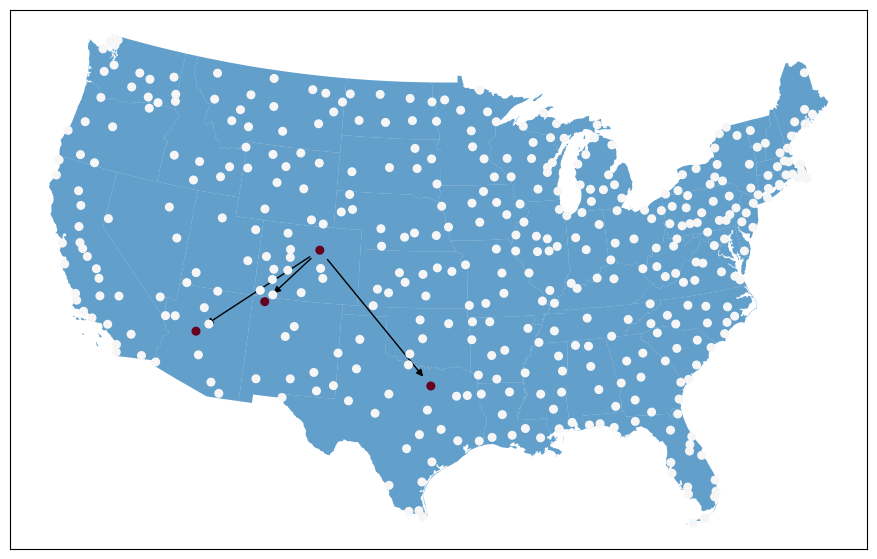

<Figure size 1200x700 with 0 Axes>

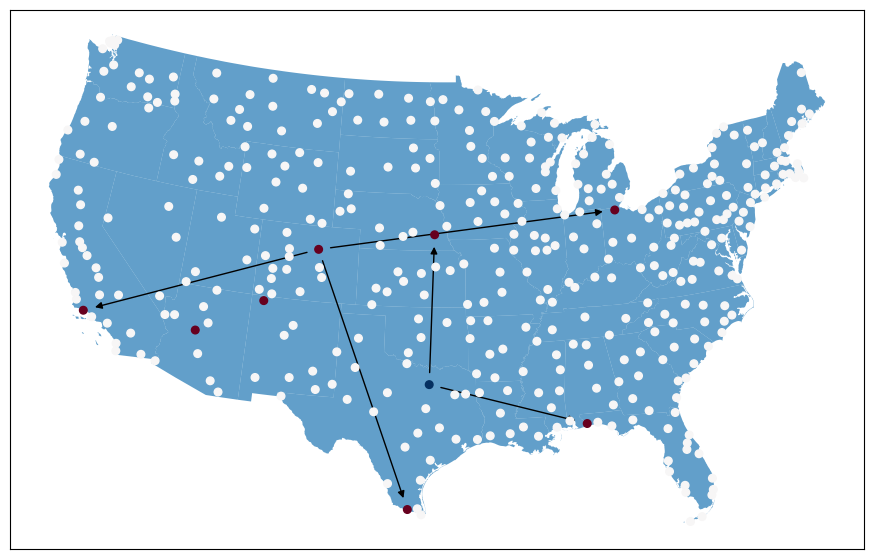

<Figure size 1200x700 with 0 Axes>

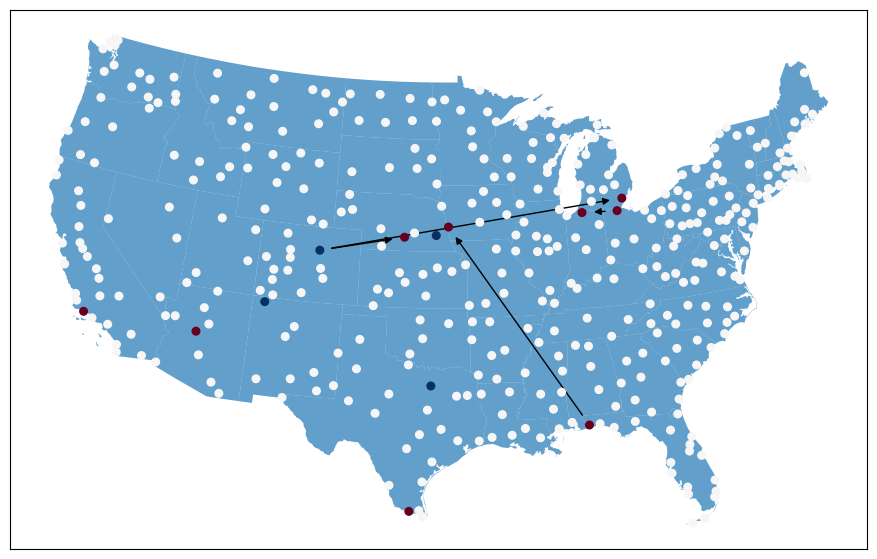

<Figure size 1200x700 with 0 Axes>

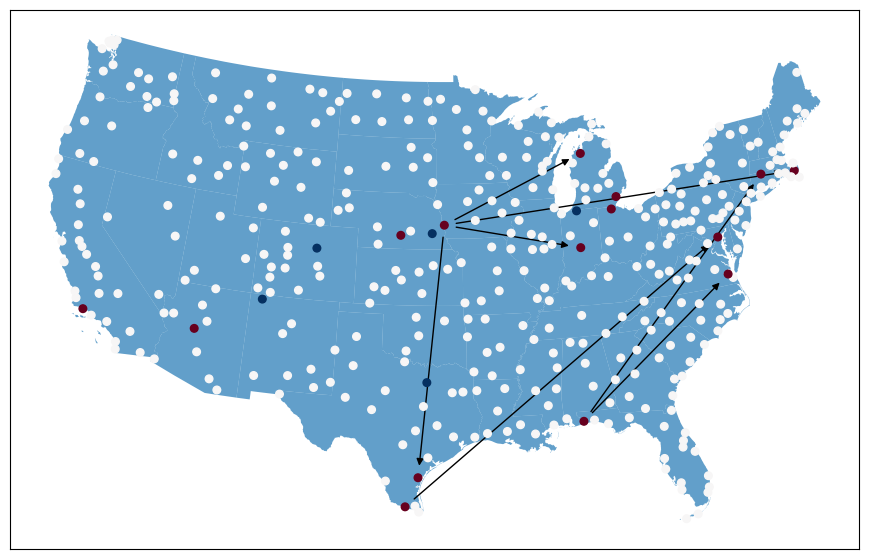

<Figure size 1200x700 with 0 Axes>

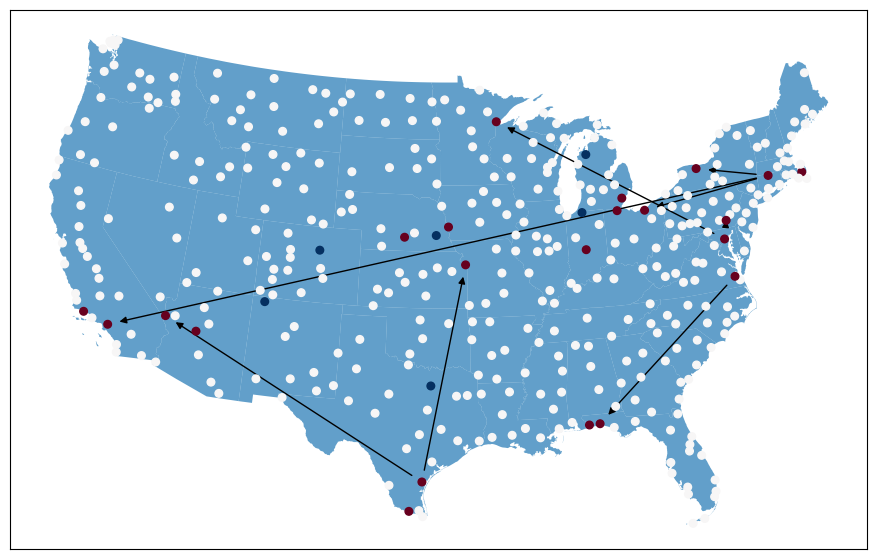

<Figure size 1200x700 with 0 Axes>

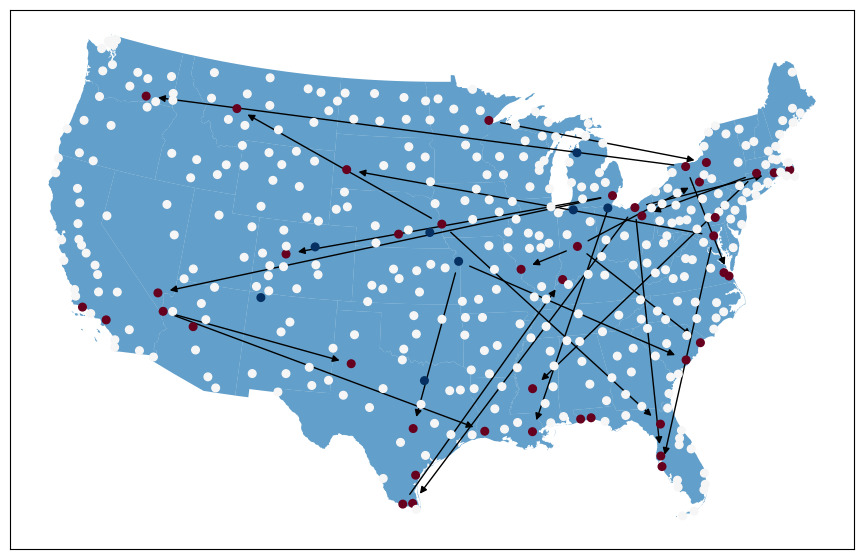

<Figure size 1200x700 with 0 Axes>

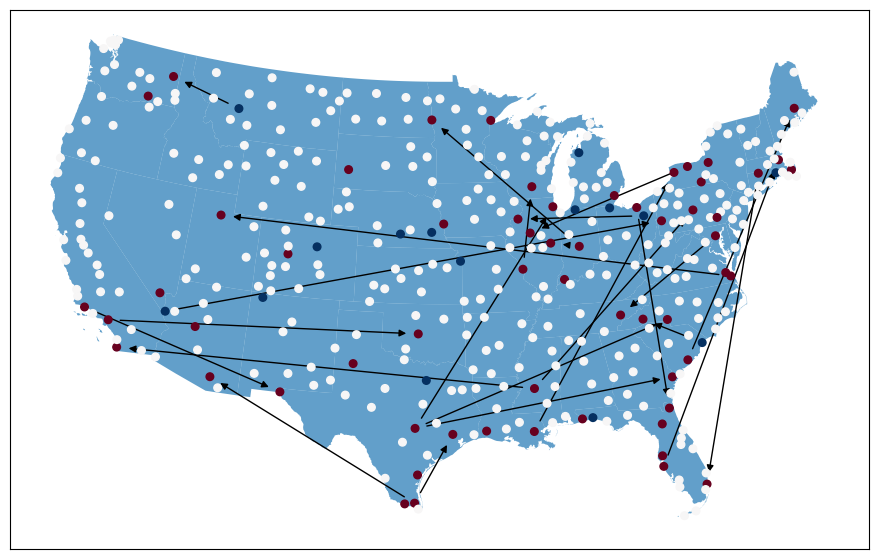

<Figure size 1200x700 with 0 Axes>

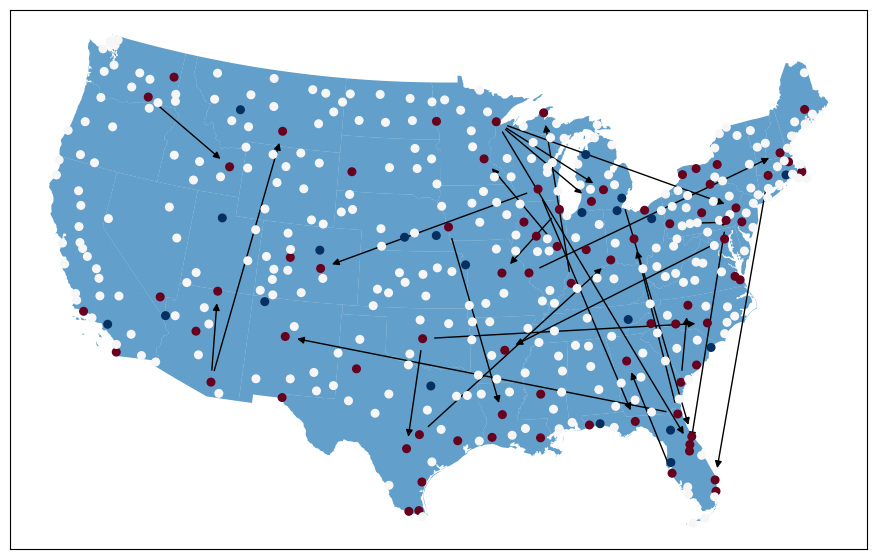

<Figure size 1200x700 with 0 Axes>

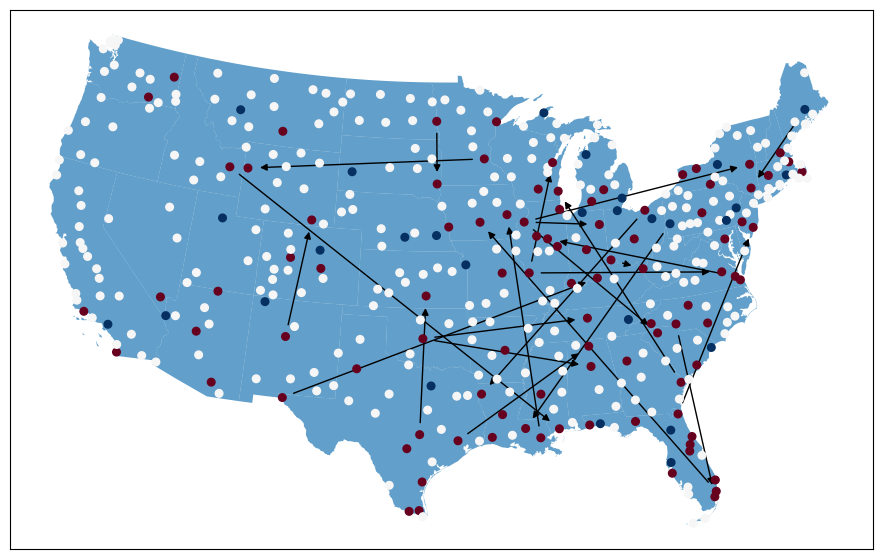

<Figure size 1200x700 with 0 Axes>

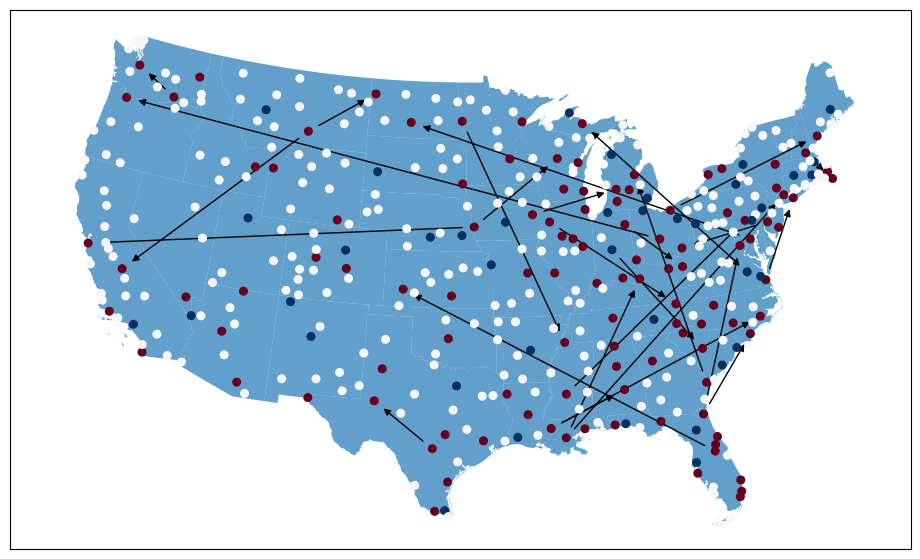

<Figure size 1200x700 with 0 Axes>

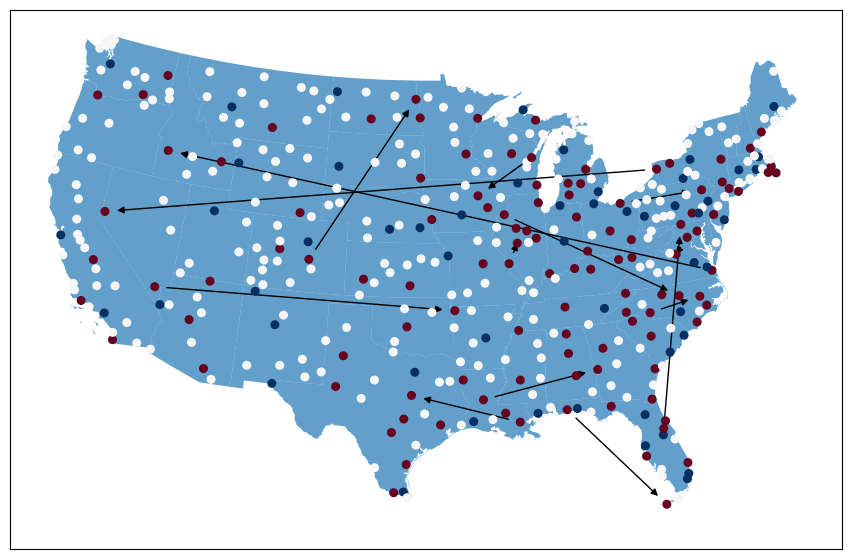

<Figure size 1200x700 with 0 Axes>

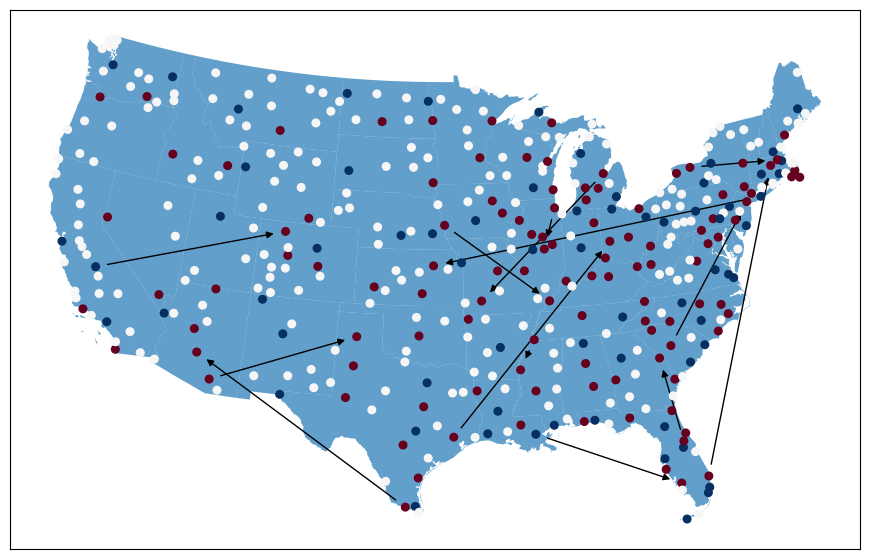

<Figure size 1200x700 with 0 Axes>

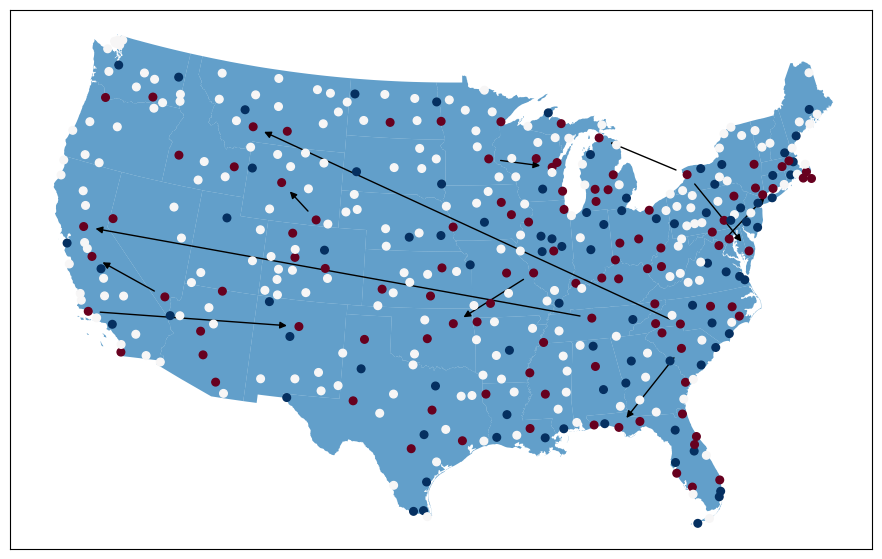

<Figure size 1200x700 with 0 Axes>

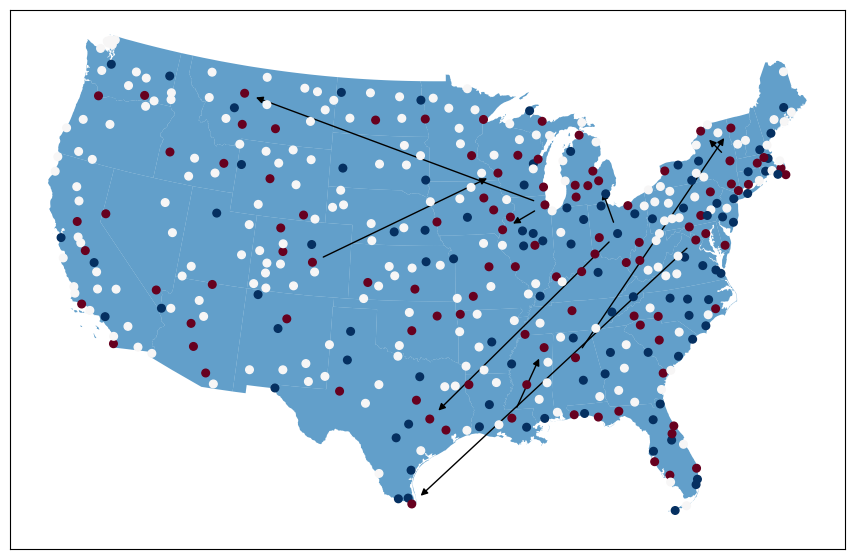

<Figure size 1200x700 with 0 Axes>

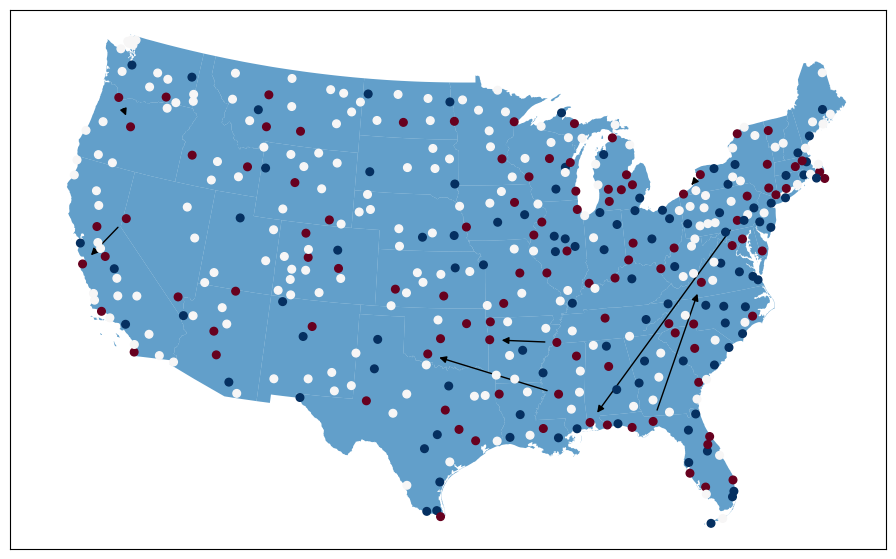

In [39]:
inf_G = nx.DiGraph()

while len(infected_nodes) > 0 and t < 15:
    
    for i in infected_nodes:
        for j in G.neighbors(i):
            if G.disease_status[j] == 0:
                p = np.random.random()
                if p < lambd:
                    G.disease_status[j] = 1
                    inf_G.add_edge(i,j)

    for k in infected_nodes:
        p = np.random.random()
        if p < mu:
            G.disease_status[k] = -1

    infected_nodes = []
    for n in G.nodes():
        if G.disease_status[n] == 1:
            infected_nodes.append(n)

    t += 1
    node_color = [G.disease_status[v] for v in G]  # color code on disease status

    plt.figure(figsize=(12, 7))
    
    ax = usa_cont_alb.plot(figsize=(12, 7), alpha=0.7)
    
    nx.draw_networkx_nodes(
        G,
        pos=G.pos_new,
        node_size=30,
        node_color=node_color,
        cmap=plt.cm.RdBu_r,
        vmin=-1,
        vmax=1,
    )
    
    nx.draw_networkx_edges(
        inf_G,
        pos=G.pos_new,
    )
    
    inf_G.clear_edges()



---
# Exploring the epidemic threshold for different network topologies

## Epidemic threshold for homogeneous networks

We simulate the spread of an SIR on an Erdos-Renyi graph with constant recovery rate.

In [7]:
N=10000
p=0.002
G=nx.fast_gnp_random_graph(N, p)

In [8]:
nx.is_connected(G)

True

---
#### For this network the epidemic threshold can be approximated as 

$\lambda_c = \frac{\mu}{\langle k \rangle}$

In [12]:
mu=0.2

Let's compute the average degree

In [13]:
avg_deg1=2*len(G.edges)/N
avg_deg1

20.1136

In [14]:
lc=mu/avg_deg1
print(lc)

0.009943520801845518


**As expected for this network, we have $\langle k^2 \rangle \sim \langle k \rangle^2 + \langle k \rangle$**

In [15]:
sum_k2=0
for i in G.nodes():
    
    k=G.degree(i)
    sum_k2+=k*k

avg_k2=sum_k2/N
print(avg_k2)

424.3724


In [16]:
avg_deg1**2 + avg_deg1

424.6705049600001

### Simulations of an SIR process
We simulate 20 realizations of a SIR model for increasing values of $\lambda$ using the [fast_SIR function of EoN](https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.fast_SIR.html?highlight=fast_SIR)

In [16]:
np.geomspace(0.0001, 1.0, 20)

array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])

In [17]:
final_size=defaultdict(list)

for lambd in np.geomspace(0.0001, 1.0, 20):
    
    for r in range(0, 20):
        
        t, S, I, R = EoN.fast_SIR(G, lambd, mu, rho=0.05)
        
        final_size[lambd].append(R[-1]/N)

In [18]:
homo_net_size=pd.DataFrame.from_dict(final_size)

In [19]:
homo_net_size

,0.000100,0.000162,0.000264,0.000428,0.000695,0.001129,0.001833,0.002976,0.004833,0.007848,0.012743,0.020691,0.033598,0.054556,0.088587,0.143845,0.233572,0.379269,0.615848,1.000000
0,0.0503,0.0507,0.0517,0.0511,0.0521,0.0552,0.0594,0.0723,0.0872,0.1533,0.4495,0.7762,0.9366,0.9855,0.9974,0.9997,0.9999,1.0000,1.0,1.0000
1,0.0507,0.0511,0.0512,0.0529,0.0537,0.0567,0.0584,0.0716,0.0935,0.1411,0.4042,0.7819,0.9362,0.9844,0.9970,1.0000,1.0000,1.0000,1.0,1.0000
2,0.0507,0.0509,0.0512,0.0520,0.0538,0.0562,0.0595,0.0679,0.0908,0.1598,0.4502,0.7813,0.9373,0.9878,0.9977,0.9999,1.0000,1.0000,1.0,1.0000
3,0.0504,0.0507,0.0514,0.0511,0.0534,0.0574,0.0600,0.0686,0.0925,0.1422,0.4199,0.7764,0.9342,0.9842,0.9979,0.9996,1.0000,1.0000,1.0,0.9999
4,0.0509,0.0501,0.0509,0.0524,0.0552,0.0543,0.0600,0.0722,0.0916,0.1604,0.3996,0.7754,0.9418,0.9881,0.9976,0.9997,1.0000,1.0000,1.0,1.0000
5,0.0503,0.0511,0.0518,0.0516,0.0522,0.0555,0.0598,0.0650,0.0859,0.1766,0.4817,0.7899,0.9355,0.9878,0.9981,1.0000,1.0000,1.0000,1.0,1.0000
6,0.0502,0.0504,0.0511,0.0516,0.0532,0.0558,0.0608,0.0691,0.0933,0.1726,0.4440,0.7735,0.9264,0.9870,0.9976,0.9997,0.9998,1.0000,1.0,1.0000
7,0.0501,0.0504,0.0512,0.0517,0.0536,0.0558,0.0597,0.0655,0.0963,0.1658,0.4346,0.7773,0.9377,0.9870,0.9976,1.0000,0.9998,1.0000,1.0,1.0000
8,0.0500,0.0513,0.0523,0.0525,0.0525,0.0577,0.0608,0.0663,0.0921,0.1623,0.4047,0.7836,0.9378,0.9864,0.9977,0.9999,1.0000,1.0000,1.0,1.0000
9,0.0505,0.0508,0.0508,0.0515,0.0544,0.0566,0.0587,0.0710,0.0889,0.1487,0.4596,0.7791,0.9367,0.9857,0.9984,0.9996,1.0000,1.0000,1.0,1.0000


Text(0.5, 0, '$\\lambda$')

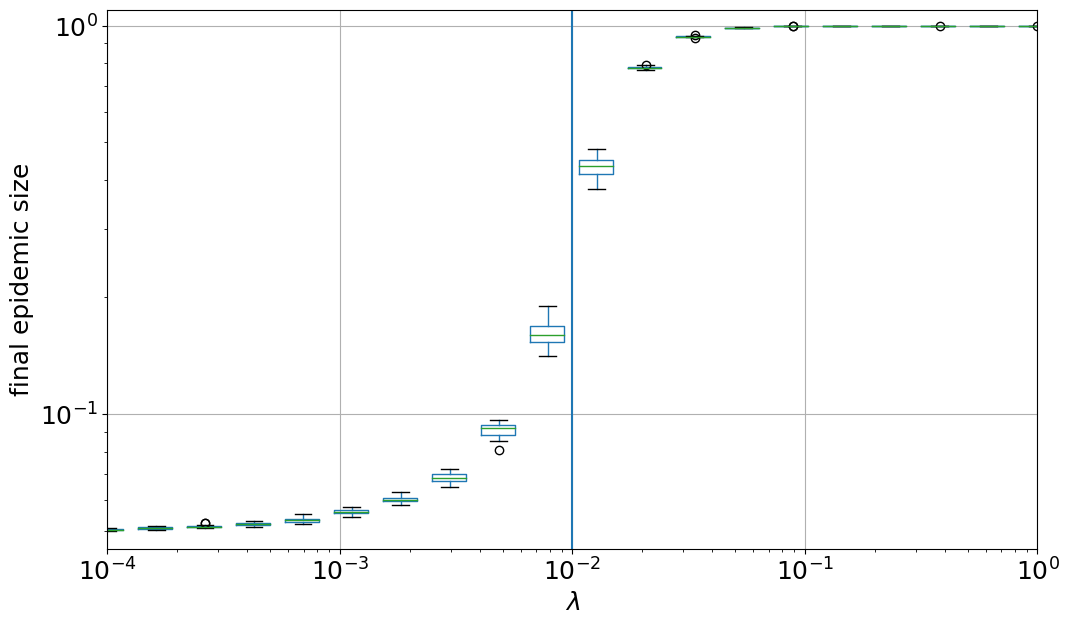

In [20]:
plt.figure(figsize=(12,7))

homo_net_size.boxplot(positions=np.array(homo_net_size.columns), 
                      widths=np.array(homo_net_size.columns)/3)

plt.vlines(x=lc, ymin=0.045, ymax=1.1)

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.0001, 1.0)
plt.ylim(0.045, 1.1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('final epidemic size', fontsize=18)
plt.xlabel('$\lambda$', fontsize=18)

## Epidemic threshold for Barabàsi-Albert model networks

In [17]:
N=10000
AB=nx.barabasi_albert_graph(N, 10)

In [18]:
nx.is_connected(AB)

True

In [20]:
avg_deg=2*len(AB.edges)/N
print(avg_deg)

19.98


In [21]:
sum_k2=0
for i in AB.nodes():
    k=AB.degree(i)
    sum_k2+=k*k
avg_k2=sum_k2/N
print(avg_k2)    

935.1042


**The threshold can be approximated as $\lambda_c \sim \mu \frac{\langle k \rangle}{\langle k^2 \rangle - \langle k \rangle}$**

In [22]:
lambda_c=mu*avg_deg/(avg_k2-avg_deg)
print(lambda_c)

0.004366620399722792


In [23]:
lc/lambda_c

2.2771662960390984

### Simulations of an SIR process
We simulate 20 realizations of a SIR model for increasing values of $\lambda$

In [28]:
final_size_AB=defaultdict(list)

for lambd in np.geomspace(0.0001, 1.0, 20):
    for r in range(0, 20):
        
        t, S, I, R = EoN.fast_SIR(AB, lambd, mu, rho=0.05)
        
        final_size_AB[lambd].append(R[-1]/N)

In [29]:
sf_net_size=pd.DataFrame.from_dict(final_size_AB)

In [30]:
sf_net_size.tail()

,0.000100,0.000162,0.000264,0.000428,0.000695,0.001129,0.001833,0.002976,0.004833,0.007848,0.012743,0.020691,0.033598,0.054556,0.088587,0.143845,0.233572,0.379269,0.615848,1.000000
15,0.0503,0.0513,0.0514,0.0519,0.0537,0.0574,0.0657,0.0903,0.1501,0.2824,0.4637,0.7136,0.8852,0.9615,0.9913,0.9989,1.0000,1.0,1.0,1.0
16,0.0508,0.0514,0.0512,0.0514,0.0533,0.0570,0.0582,0.0848,0.1349,0.2646,0.4880,0.7097,0.8806,0.9619,0.9907,0.9985,1.0000,1.0,1.0,1.0
17,0.0505,0.0505,0.0511,0.0514,0.0537,0.0559,0.0653,0.0745,0.1229,0.2793,0.4641,0.7006,0.8774,0.9583,0.9908,0.9989,0.9998,1.0,1.0,1.0
18,0.0503,0.0506,0.0513,0.0520,0.0524,0.0566,0.0696,0.0784,0.1498,0.2744,0.5144,0.6974,0.8623,0.9579,0.9900,0.9983,0.9999,1.0,1.0,1.0
19,0.0507,0.0513,0.0513,0.0517,0.0533,0.0562,0.0633,0.0795,0.1308,0.2436,0.5027,0.7052,0.8760,0.9598,0.9913,0.9984,1.0000,1.0,1.0,1.0


Text(0.5, 0, '$\\lambda$')

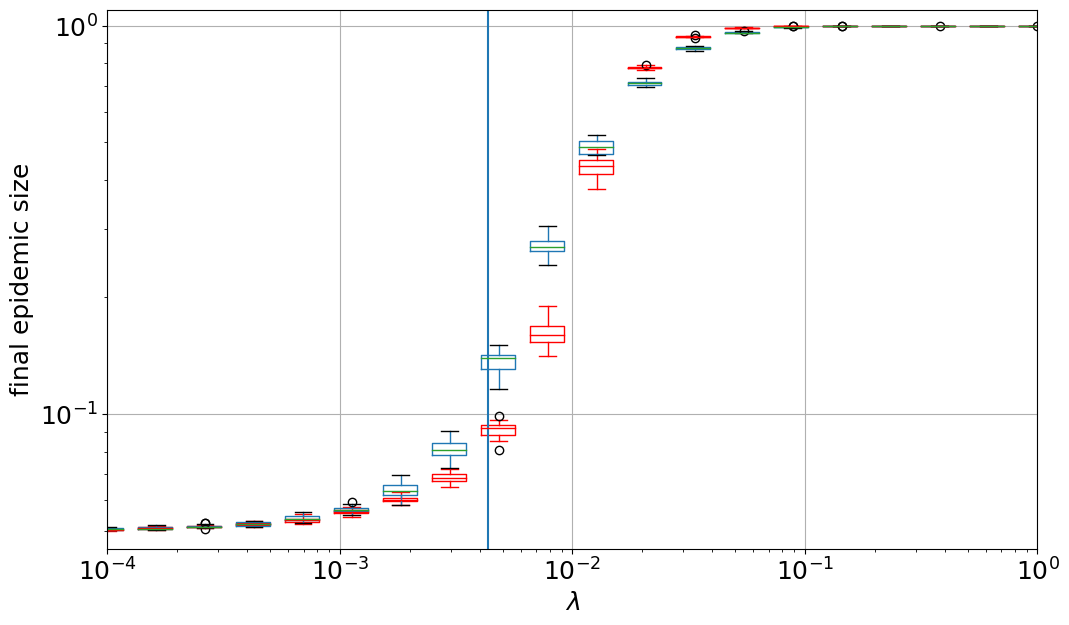

In [31]:
plt.figure(figsize=(12,7))

homo_net_size.boxplot(positions=np.array(homo_net_size.columns), widths=np.array(homo_net_size.columns)/3, color='r' )

plt.vlines(x=lambda_c, ymin=0.04, ymax=1.1)
sf_net_size.boxplot(positions=np.array(sf_net_size.columns), widths=np.array(sf_net_size.columns)/3)

plt.yscale('log')
plt.xscale('log')
plt.xlim(0.0001, 1.0)
plt.ylim(0.045, 1.1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('final epidemic size', fontsize=18)
plt.xlabel('$\lambda$', fontsize=18)

## Epidemic threshold for configuration model networks

We can use the configuration model to generate a network with a given power-law degree distribution. By setting $\gamma=2.1$, we expect to see more fluctuations in the degree distribution.

In [26]:
import numpy.random as random

We create a function that samples from a power-law distribution between $k_{min}$ and $k_{max}$ with exponent $\gamma$

In [41]:
def get_activity(x0,x1,g):
    
    y=random.uniform(0,1)
    
    e=g+1.
    
    a=((x1**e-x0**e)*y+x0**e)**(1./e)
    
    return a

In [52]:
N=10000
kmin=2
kmax=N-1
a=[]
for i in range(N):
    act=get_activity(kmin,kmax,-2.1)
    
    a.append(int(round(act))*2)

#we need the sum of the degree sequence to be even to properly run the configuration model
if sum(a)%2==0:
    G1=nx.configuration_model(a)
else:
    a[-1]+=1
    G1=nx.configuration_model(a)

In [53]:
nx.is_connected(G1)

True

In [54]:
G1

In [55]:
G1=nx.Graph(G1)

In [56]:
G1.remove_edges_from(nx.selfloop_edges(G1))

In [57]:
nx.is_connected(G1)

True

In [58]:
sum_k2=0
for i in G1.nodes():
    k=G1.degree(i)
    sum_k2+=k*k
avg_k2=sum_k2/N
print(avg_k2)

6512.2418


In [59]:
avg_deg=2*len(G1.edges)/N
print(avg_deg)

20.1512


In [60]:
lambda_c1=mu*avg_deg/(avg_k2-avg_deg)
print(lambda_c1)

0.0006207923222759708


In [61]:
lc/lambda_c1

16.01746742838286

### Simulations of an SIR process
We simulate 100 realizations of a SIR model for increasing values of $\lambda$

In [48]:
final_size_conf=defaultdict(list)

for lambd in np.geomspace(0.0001, 1.0, 20):
    for r in range(0, 20):
        
        t, S, I, R = EoN.fast_SIR(G1, lambd, mu, rho=0.05)
        
        final_size_conf[lambd].append(R[-1]/N)

In [49]:
conf_net_size=pd.DataFrame.from_dict(final_size_conf)

Text(0.5, 0, '$\\lambda$')

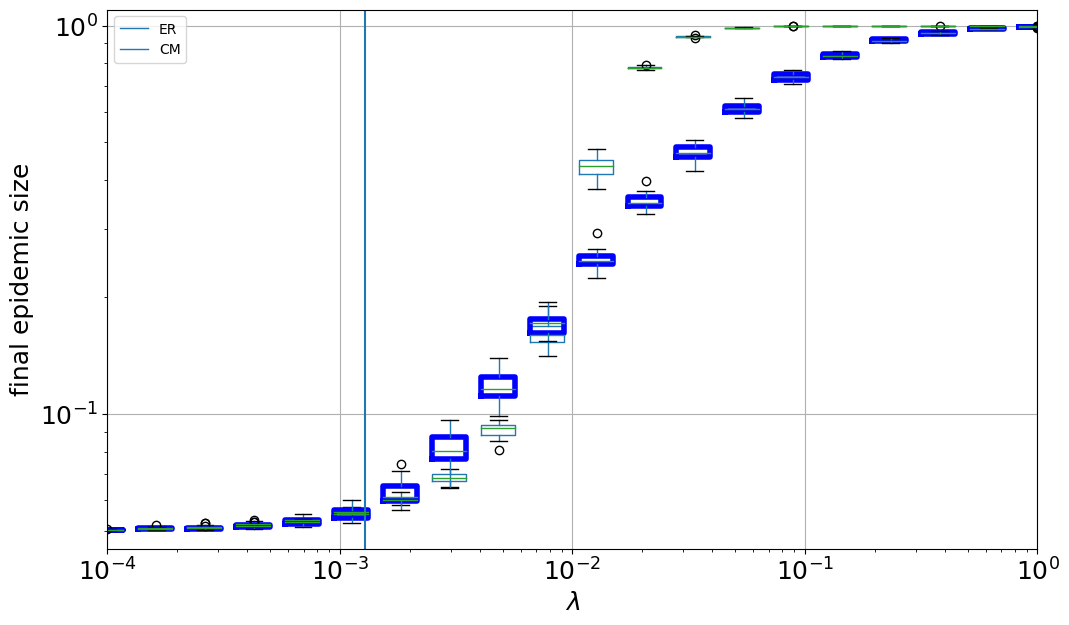

In [50]:
plt.figure(figsize=(12,7))

boxprops1 = dict(linestyle='-', linewidth=3, color='r')

homo_net_size.boxplot(positions=np.array(homo_net_size.columns), widths=np.array(homo_net_size.columns)/3)

conf_net_size.boxplot(positions=np.array(conf_net_size.columns), widths=np.array(conf_net_size.columns)/3, boxprops=boxprops1)

plt.vlines(x=lambda_c1, ymin=0.04, ymax=1.1)
plt.legend(['ER','CM'])
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.0001, 1.0)
plt.ylim(0.045, 1.1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('final epidemic size', fontsize=18)
plt.xlabel('$\lambda$', fontsize=18)